In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm
from scipy.stats import t as t_dist
import numpy as np
from scipy.stats import ttest_ind
from copy import deepcopy
import statsmodels.api as sm
import numpy as np

In [2]:
#load the cleaned data
raw_data = pd.read_csv('train_clean.csv')

In [3]:
#group the data by visCountryId and destinationId
df_dict = {}
grouped = raw_data.groupby(['visCountryId','destinationId'])
for name, group in grouped:
    if group[group["position"] == 1].shape[0] >= 250:
        df_dict[name] = group

In [4]:
#store the outcome of the first position for each search
pop_data = []
for i in df_dict.keys():
    group1 = []
    group2 = []
    group_df = df_dict[i].groupby('srch_id')
    for name, group in group_df:
        if group['random_bool'].iloc[0] == 0:
            group1.append(np.sum(group[group.position == 1]['booking_bool']))
        else:
            group2.append(np.sum(group[group.position == 1]['booking_bool']))
    pop_data.append([group1,group2])

In [5]:
#calculate the true tau
true_tao = []
for i in range(len(pop_data)):
    tau1 = pop_data[i][0]
    tau2 = pop_data[i][1]
    true_tao.append(np.mean(tau1) - np.mean(tau2))
true_tao1 = np.array(true_tao)

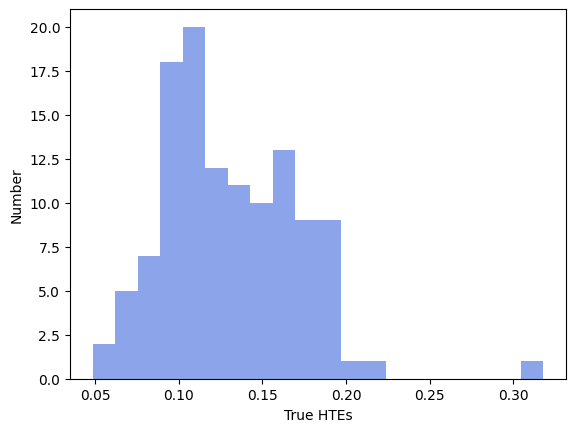

In [6]:
plt.hist(true_tao, color = '#8CA5EA' , bins=20)
plt.xlabel('True HTEs')
plt.ylabel("Number")
plt.savefig('true_ate_in_Expedia.png', dpi=300, bbox_inches='tight')


In [7]:
#calculate the weight for each group
weight = []
for i in range(len(pop_data)):
    tau1 = pop_data[i][0]
    tau2 = pop_data[i][1]
    weight.append(len(tau1) + len(tau2))
weight = np.array(weight)
weight = weight/np.sum(weight)

In [20]:
T = 1000
N_list = [0.05,0.1,0.15,0.2,0.25]
cost = np.zeros((len(N_list),3,T))
decision_right_rate = np.zeros((len(N_list),2,2,T))


K = true_tao1.shape[0]
tau_min = 0.1
true_tao = true_tao1 - tau_min
optimal_cost = np.sum(true_tao[np.argwhere(true_tao>0)]*weight[np.argwhere(true_tao>0)])

estimated_tau = np.zeros((len(N_list),T,K))
calculte_zeros = np.zeros((2,T))
alpha = 0.05
Z = norm.ppf( 1 - alpha/2)
for idx,ratio in enumerate(N_list):
    N_array = np.zeros(K)
    for k in range(K):
        N_array[k] = int((len(pop_data[k][0]) + len(pop_data[k][1]))*ratio)
        #N_array[k] = ratio
    for t in tqdm(range(T)):
        #hist_data = np.zeros((K,N,2))
        tao_hat = np.zeros(K)
        variance = np.zeros(K)
        #upper_bound_list = np.zeros(K)
        p_value_list = np.zeros(K)
        
        group_hist = []
        select_list = []
        for k in range(K):
            group_1 = np.array(np.random.choice(pop_data[k][0],int(N_array[k]/2),replace=True))
            group_0 = np.array(np.random.choice(pop_data[k][1],int(N_array[k]) - int(N_array[k]/2),replace=True))
            group_hist.append([group_1,group_0])
            
            diff_mean = group_1.mean() - group_0.mean()
            if np.std(group_1) == 0 and np.std(group_0) == 0:
                p_value = 0
            else:
                t_stat, p_value = ttest_ind(group_1, group_0, equal_var = False) 
                tao_hat[k] = diff_mean
                p_value_list[k] = p_value
                variance[k] = N_array[k]*(group_1.var(ddof=1) / len(group_1) + group_0.var(ddof=1) / len(group_0))
                select_list.append(k)
    
        decision1 = np.intersect1d(np.argwhere(p_value_list<alpha), np.argwhere(tao_hat>tau_min))
            
        tao_0 = np.mean(tao_hat)
        numerator = np.mean(variance)
        denumerator = np.mean((tao_hat - tao_0)**2) - np.mean(variance/N_array)

        bayesian_tao = np.zeros(K)
        bayesian_beta = np.zeros(K)
        p_value_list_bayesian = np.ones(K)
        #bayesian_variance = np.zeros(K)
        for k in select_list:
            if tao_0 == 0 or denumerator <= 0:
                bayesian_beta[k] = 0
            else:
                bayesian_beta[k] = max(variance[k]/denumerator,0)
        decision4 = []
        for k in select_list:
            theta = N_array[k]/(N_array[k]+bayesian_beta[k])
            #Y_shunken = theta*Y_shunken 
            group_12 = theta*group_hist[k][0] + (1-theta)*tao_0
            group_02 = theta*group_hist[k][1]
            t_stat, p_value = ttest_ind(group_12, group_02, equal_var = False)  
            diff_mean1 = group_12.mean() - group_02.mean()
            bayesian_tao[k] = diff_mean1
            p_value_list_bayesian[k] = p_value
            if diff_mean1 - tau_min > norm.ppf(0.975)*theta*np.sqrt(variance[k]/N_array[k]):
                decision4.append(k)

        # bayesian_tao = np.zeros(K)
        # bayesian_beta = np.zeros(K)
        # p_value_list_bayesian = np.zeros(K)
        # #bayesian_variance = np.zeros(K)
        # for k in range(K):
        #     bayesian_beta[k] = max(variance[k]/denumerator,0)
        #     #bayesian_tao[k] = ((tao_0/denumerator) + tao_hat[k]*N/variance[k])/(1/denumerator + 1*N/variance[k])
        #     #bayesian_variance[k] = 1/(1/9 + 1/variance[k])
        # #Y_shunken = deepcopy(Y)
        # for k in range(K):
        #     theta = N_array[k]/(N_array[k]+bayesian_beta[k])
        #     #Y_shunken = theta*Y_shunken 
        #     group_12 = theta*group_hist[k][0] + (1-theta)*tao_0
        #     group_02 = theta*group_hist[k][1]
        #     t_stat, p_value = ttest_ind(group_12, group_02, equal_var = False)  
        #     diff_mean1 = group_12.mean() - group_02.mean()
        #     bayesian_tao[k] = diff_mean1
        #     p_value_list_bayesian[k] = p_value
        # decision3 = np.intersect1d(np.argwhere(p_value_list_bayesian<alpha), np.argwhere(bayesian_tao>tau_min))


        if tao_0 == 0:
            beta = 0
        else:
            beta = numerator/denumerator + Z*np.sqrt(np.mean(N_array*variance))/tao_0

        theta_array = np.zeros(K)
        for k in range(K):
            theta_array[k] = N_array[k]/(beta + N_array[k])

        
        

        tao_shunken_hat = np.zeros(K)
        p_value_list_shrunken = np.zeros(K)
    
        for k in select_list:
            group_11 = theta_array[k]*group_hist[k][0] + (1-theta_array[k])*tao_0
            group_00 = theta_array[k]*group_hist[k][1]
            if np.std(group_11) == 0 and np.std(group_00) == 0:
                p_value = 0
            else:
                t_stat, p_value = ttest_ind(group_11, group_00, equal_var = False)
    
            diff_mean1 = group_11.mean() - group_00.mean()
            tao_shunken_hat[k] = diff_mean1
            p_value_list_shrunken[k] = p_value
        
        decision2 = np.intersect1d(np.argwhere(p_value_list_shrunken<alpha), np.argwhere(tao_shunken_hat>tau_min))
        #decision3 = np.argwhere(bayesian_tao>tau_min)
        cost[idx,0,t] = np.sum(true_tao[decision1]*weight[decision1])/optimal_cost
        cost[idx,1,t] = np.sum(true_tao[decision2]*weight[decision2])/optimal_cost
        cost[idx,2,t] = np.sum(true_tao[decision4]*weight[decision4])/optimal_cost
       
        negative_right1 = 0
        negative_right2 = 0
        positive_right1 = 0
        positive_right2 = 0
        for k in range(K):
            if true_tao[k] < 0 and k not in decision1:
                negative_right1 += 1
            if true_tao[k] < 0 and k not in decision2:
                negative_right2 += 1
            if true_tao[k] > 0 and k in decision1:
                positive_right1 += 1
            if true_tao[k] > 0 and k in decision2:
                positive_right2 += 1
        decision_right_rate[idx,0,0,t] = positive_right1/(len(np.argwhere(true_tao>0)))
        decision_right_rate[idx,1,0,t] = positive_right2/(len(np.argwhere(true_tao>0)))
        decision_right_rate[idx,0,1,t] = negative_right1/(len(np.argwhere(true_tao<0)))
        decision_right_rate[idx,1,1,t] = negative_right2/(len(np.argwhere(true_tao<0)))

    # #print(theta)
    # tao_shunken_hat = np.zeros(K)
    # for i in range(K):
    #     tao_shunken_hat[i] = theta*tao_hat[i] + (1-theta)*tao_0
    # cost[0,t] = np.sum(true_tao[np.argwhere(tao_hat>(Z*np.sqrt(variance))/np.sqrt(N))])/optimal_cost
    # cost[1,t] = np.sum(true_tao[np.argwhere(tao_shunken_hat>(Z*np.sqrt(variance)*theta)/np.sqrt(N))])/optimal_cost
    # decision1 = []
    # for k in range(K):
    #     if p_value_list[k] < 0.05 and tao_hat[k] > 0:
    #         decision1.append(k)
    # cost[2,t] = np.sum(true_tao[decision1])/optimal_cost

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/xubo/anaconda3/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 1000/1000 [03:35<00:00,  4.64it/s]


In [21]:
cost_mean = np.mean(cost[:,:,:],axis=2)
cost_mean

array([[0.17350345, 0.70948336, 0.36573803],
       [0.45998406, 0.84700821, 0.53312359],
       [0.6550899 , 0.87799833, 0.58179458],
       [0.76589487, 0.88894844, 0.59014221],
       [0.81467138, 0.89760714, 0.59329623]])

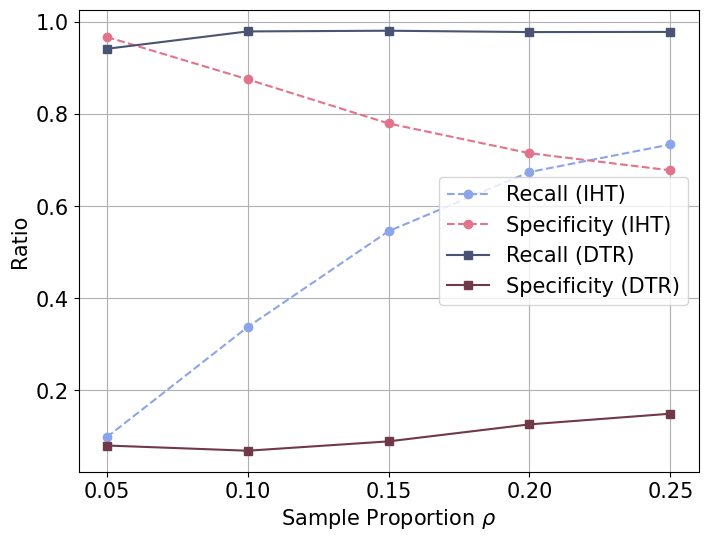

In [15]:
plt.figure(figsize=(8,6))
plt.xlabel(r'Sample Proportion $\rho$',fontsize=15)
plt.ylabel('Ratio',fontsize=15)
x = N_list

y_positve = np.mean(decision_right_rate[:,0,:,:],axis=2)[:,0]
y_negative = np.mean(decision_right_rate[:,0,:,:],axis=2)[:,1]
plt.plot(x, y_positve, color = '#8CA5EA',linestyle = '--', marker='o',label = "Recall (IHT)")
plt.plot(x, y_negative, color = '#E3738B',linestyle = '--', marker='o',label = "Specificity (IHT)")

y_positve = np.mean(decision_right_rate[:,1,:,:],axis=2)[:,0]
y_negative = np.mean(decision_right_rate[:,1,:,:],axis=2)[:,1]
plt.plot(x, y_positve, color = '#495373', marker='s',label = "Recall (DTR)")
plt.plot(x, y_negative, color = '#713948', marker='s',label = "Specificity (DTR)")

plt.xticks(x,fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.savefig('right_decision_cutoff_{}_proportion.png'.format(tau_min),dpi=300,bbox_inches = 'tight')
plt.show()

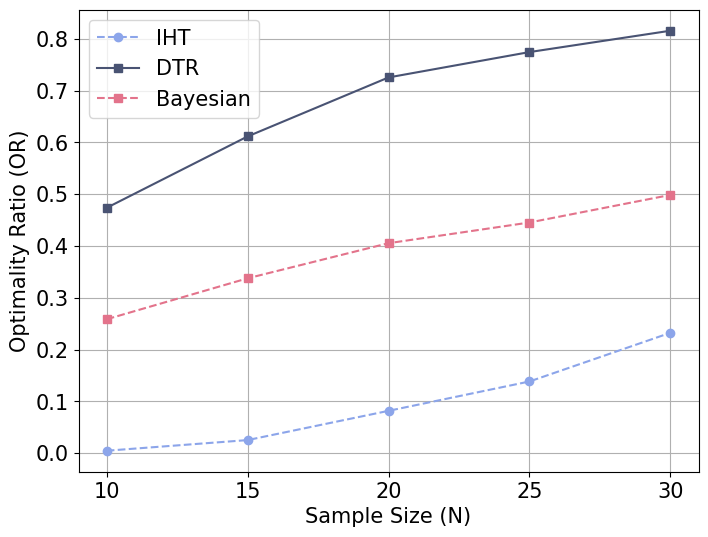

In [19]:
plt.figure(figsize=(8,6))
plt.xlabel(r'Sample Size (N)',fontsize=15)
plt.ylabel('Optimality Ratio (OR)',fontsize=15)
x = N_list

y3 = np.mean(cost,axis=2)[:,0]
plt.plot(x, y3, color = '#8CA5EA',linestyle = '--', marker='o',label = "IHT")

y3 = np.mean(cost,axis=2)[:,1]
plt.plot(x, y3, color = '#495373',marker = "s",label = "DTR")

y3 = np.mean(cost,axis=2)[:,2]
plt.plot(x, y3, color = '#E3738B',marker = "s",label = "Bayesian",linestyle = '--')

plt.xticks(x,fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.savefig('real_data_OR_compare_with_N_cutoff_with_bayesian_{}.png'.format(tau_min),dpi=300,bbox_inches = 'tight')
plt.show()

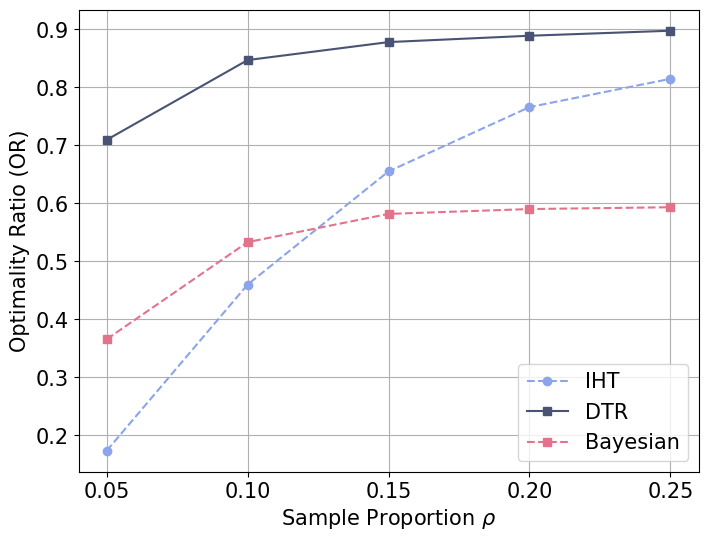

In [22]:
plt.figure(figsize=(8,6))
plt.xlabel(r'Sample Proportion $\rho$',fontsize=15)
plt.ylabel('Optimality Ratio (OR)',fontsize=15)
x = N_list

y3 = np.mean(cost,axis=2)[:,0]
plt.plot(x, y3, color = '#8CA5EA',linestyle = '--', marker='o',label = "IHT")

y3 = np.mean(cost,axis=2)[:,1]
plt.plot(x, y3, color = '#495373',marker = "s",label = "DTR")

y3 = np.mean(cost,axis=2)[:,2]
plt.plot(x, y3, color = '#E3738B',marker = "s",label = "Bayesian",linestyle = '--')

plt.xticks(x,fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.savefig('real_data_OR_compare_with_proportion_cutoff_with_bayesian_{}.png'.format(tau_min),dpi=300,bbox_inches = 'tight')
plt.show()

In [11]:
tau_min

0.05

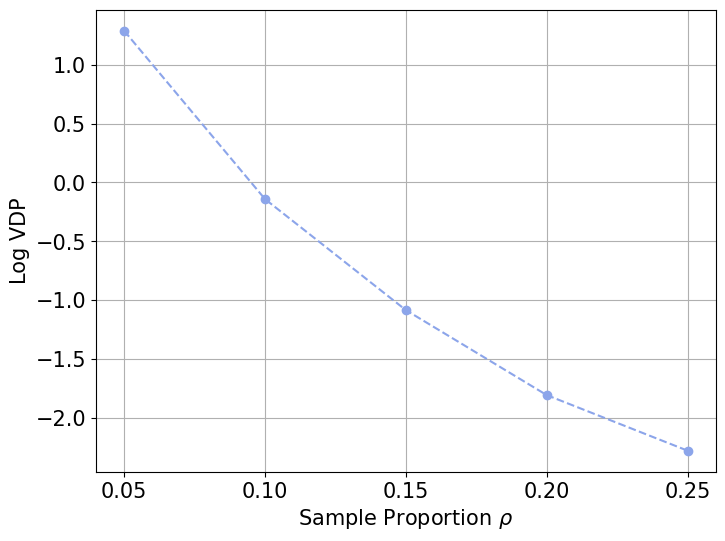

In [16]:
x = N_list
y1 =  np.mean(cost,axis=2)[:,0]
y2 = np.mean(cost,axis=2)[:,1]
plt.figure(figsize=(8,6))
plt.xlabel(r'Sample Proportion $\rho$',fontsize=15)
plt.ylabel('Log VDP',fontsize=15)

plt.plot(x, [np.log(y2[i]/y1[i] - 1) for i in range(5)], color = '#8CA5EA',linestyle = '--', marker='o')

plt.xticks(x,fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.savefig('real_data_VDP_compare_with_proportion_cutoff_{}.png'.format(tau_min),dpi=300,bbox_inches = 'tight')
plt.show()

/var/folders/1k/b5ntvdmn14d6y71h586c2n540000gn/T/ipykernel_9439/1699903131.py:28: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0,1,0.1)


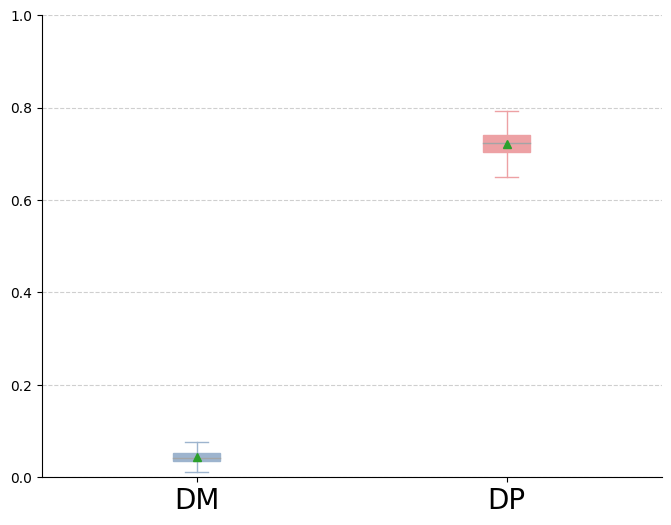

In [15]:
fig, ax = plt.subplots(figsize = (8,6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
data = [cost[0,:],cost[1,:]]

bp = plt.boxplot(data,showfliers=False,showmeans=True,patch_artist=True)
# 定义每个箱子的颜色
colors = [ '#9DB4CE','#EDA1A4']
colors1 = ['#A3A5A6' ,'#A3A5A6']

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    
for whisker, color in zip(bp['whiskers'], [colors[i // 2] for i in range(len(bp['whiskers']))]):
    whisker.set_color(color)

for cap, color in zip(bp['caps'], [colors[i // 2] for i in range(len(bp['caps']))]):
    cap.set_color(color)

for median, color in zip(bp['medians'], colors1):
    median.set_color(color)

for flier, color in zip(bp['fliers'], [colors[i // 2] for i in range(len(bp['fliers']))]):
    flier.set_markerfacecolor(color)
    flier.set_markeredgecolor(color)

plt.ylim(0,1,0.1)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
# 设置x轴标签
plt.xticks([1, 2], ['DM','DP'],fontsize=20)

# 设置y轴标签
#plt.ylabel('Values')
# 设置图标题
#plt.title('Boxplot of Different Groups')

# 显示图形
#plt.savefig('..//figures//boxplot_constant_10_K_100.png',dpi = 300,bbox_inches = 'tight')
plt.show()

In [81]:
eatimeted_tau = []
for i in df_dict.keys():
    tau1 = []
    tau2 = []
    array_temp = np.zeros((len(df_dict[i]),2))
    array_temp[:,0] = df_dict[i]['booking_bool']
    array_temp[:,1] = df_dict[i]['random_bool']
    size = np.random.choice(range(array_temp.shape[0]), 100)
    estimated_tau1 = np.sum(array_temp[size,0]*(1-array_temp[size,1]))/np.sum(1-array_temp[size,1]) - np.sum(array_temp[size,0]*array_temp[size,1])/np.sum(array_temp[size,1])
    eatimeted_tau.append(estimated_tau1)

In [64]:
len(eatimeted_tau)

51

(array([ 1.,  0.,  0.,  0.,  0.,  4.,  4.,  9., 22., 44., 41., 46., 26.,
        21., 17.,  7.,  3.,  1.,  1.,  1.]),
 array([-0.08888889, -0.07844444, -0.068     , -0.05755556, -0.04711111,
        -0.03666667, -0.02622222, -0.01577778, -0.00533333,  0.00511111,
         0.01555556,  0.026     ,  0.03644444,  0.04688889,  0.05733333,
         0.06777778,  0.07822222,  0.08866667,  0.09911111,  0.10955556,
         0.12      ]),
 <BarContainer object of 20 artists>)

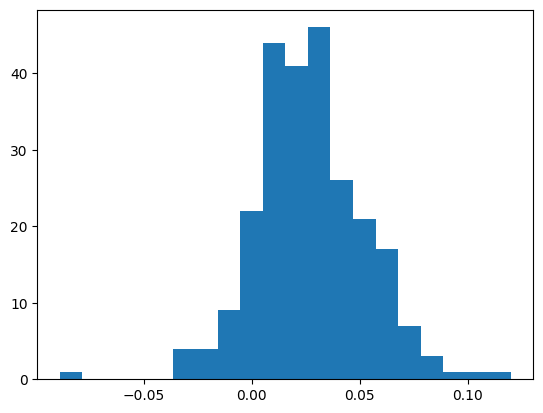

In [82]:
plt.hist(eatimeted_tau,bins = 20)

Text(0, 0.5, 'Number of instances')

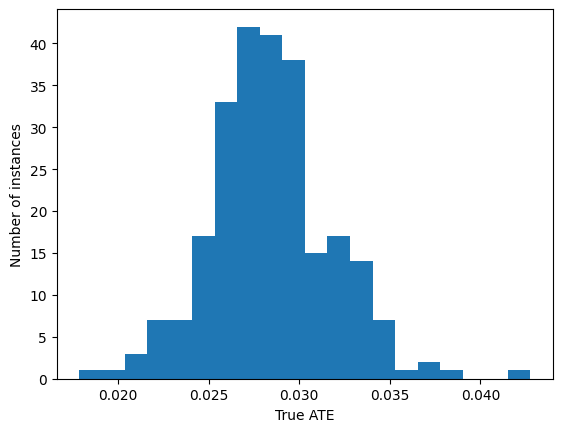

In [12]:
plt.hist(true_tao, bins=20)
plt.xlabel('True ATE')
plt.ylabel('Number of instances')